In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import fbeta_score
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score
sns.set_style('darkgrid')

# Loading the Data
##### This dataset was collected from a local clinic in Northern Mindanao, Philippines. This was collected for the fulfillment of a research paper by Agdeppa et al. (2023)

In [2]:
df = pd.read_csv('urinalysis_tests.csv')

In [3]:
df

,Unnamed: 0,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,0,76.00,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,1,9.00,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,2,12.00,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,3,77.00,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,4,29.00,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,1431,0.06,MALE,YELLOW,CLEAR,NEGATIVE,NEGATIVE,6.0,1.015,1-2,0-1,RARE,FEW,NONE SEEN,RARE,NEGATIVE
1432,1432,42.00,MALE,YELLOW,CLEAR,NEGATIVE,NEGATIVE,6.5,1.010,0-2,0-2,RARE,NONE SEEN,NONE SEEN,RARE,NEGATIVE
1433,1433,47.00,FEMALE,DARK YELLOW,CLEAR,NEGATIVE,TRACE,6.0,1.030,2-4,0-2,MODERATE,MODERATE,NONE SEEN,RARE,NEGATIVE
1434,1434,57.00,FEMALE,DARK YELLOW,CLEAR,NEGATIVE,TRACE,5.0,1.030,0-2,0-2,PLENTY,PLENTY,NONE SEEN,FEW,NEGATIVE


In [4]:
(df['WBC'] == 'TNTC').sum()

4

In [83]:
df['Specific Gravity'].min()

1.005

In [5]:
df['Glucose'].unique()

array(['NEGATIVE', '3+', '1+', 'TRACE', '4+', '2+'], dtype=object)

In [6]:
df['RBC'].value_counts()

0-2       618
0-1       312
1-2       123
1-3        87
2-4        72
0-3        49
3-5        27
4-6        24
>50        13
5-7        10
>100       10
8-10       10
18-20       6
13-15       5
2-3         5
10-12       5
1-5         4
6-8         4
LOADED      4
1-4         3
0-4         3
9-11        3
5-10        2
5-8         2
23-25       2
30-35       2
1-6         2
16-18       2
2-5         2
3-6         2
28-30       1
12-15       1
4-10        1
48-62       1
25-32       1
25-30       1
20-25       1
2-6         1
8-12        1
12-17       1
11-13       1
TNTC        1
22-24       1
0-0         1
85-87       1
36-38       1
20-22       1
18-21       1
18-25       1
18-22       1
9-12        1
6-14        1
38-40       1
Name: RBC, dtype: int64

In [7]:
df['Color'].value_counts()

YELLOW            710
LIGHT YELLOW      341
DARK YELLOW       248
STRAW             116
AMBER              15
BROWN               1
RED                 1
REDDISH             1
REDDISH YELLOW      1
LIGHT RED           1
Name: Color, dtype: int64

In [8]:
df.duplicated().sum()

0

## Inspecting the data
#### Perform EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1436 non-null   int64  
 1   Age               1436 non-null   float64
 2   Gender            1436 non-null   object 
 3   Color             1435 non-null   object 
 4   Transparency      1436 non-null   object 
 5   Glucose           1436 non-null   object 
 6   Protein           1436 non-null   object 
 7   pH                1436 non-null   float64
 8   Specific Gravity  1436 non-null   float64
 9   WBC               1436 non-null   object 
 10  RBC               1436 non-null   object 
 11  Epithelial Cells  1436 non-null   object 
 12  Mucous Threads    1436 non-null   object 
 13  Amorphous Urates  1436 non-null   object 
 14  Bacteria          1436 non-null   object 
 15  Diagnosis         1436 non-null   object 
dtypes: float64(3), int64(1), object(12)
memory

In [10]:
numerical_features = df.select_dtypes(include=['float']).columns.to_list()
numerical_features

['Age', 'pH', 'Specific Gravity']

In [11]:
categorical_features = df.select_dtypes(include=['object']).columns.to_list()

for c in categorical_features:
    print("--", c, ": ", df[c].unique())

-- Gender :  ['FEMALE' 'MALE']
-- Color :  ['LIGHT YELLOW' 'DARK YELLOW' 'BROWN' 'YELLOW' 'AMBER' 'STRAW' 'RED'
 'REDDISH' 'REDDISH YELLOW' 'LIGHT RED' nan]
-- Transparency :  ['CLEAR' 'SLIGHTLY HAZY' 'CLOUDY' 'HAZY' 'TURBID']
-- Glucose :  ['NEGATIVE' '3+' '1+' 'TRACE' '4+' '2+']
-- Protein :  ['NEGATIVE' '1+' 'TRACE' '2+' '3+']
-- WBC :  ['1-3' '0-3' '5-8' '1-4' '3-5' '70-75' '0-2' '1-2' '2-4' '6-8' '8-10'
 '10-12' '0-1' '4-6' '20-25' '25-30' '18-25' '3-6' 'LOADED' '28-30' '5-7'
 '12-15' '15-17' '30-35' '8-12' '2-3' '35-40' '50-55' '11-15' '48-55'
 '45-50' '12-14' '14-16' '17-20' '55-58' '9-11' '>50' '15-20' '20-22'
 '18-20' '7-9' 'TNTC' '2-5' '34-36' '30-32' '23-25' '5-10' '9-15' '13-15'
 '4-8' '11-14' '10-16' '7-15' '7-8' '0-4' '15-22' '15-21' '>100' '7-10'
 '15-28' '1-5' '4-5' '2-7' '3-7' '10-15' '4-7' '79-85' '28-35' '3-10'
 '5-6' '3-4' '15-18' '4-10' '10-18' '8-11']
-- RBC :  ['0-2' 'LOADED' '1-2' '2-4' '0-1' '6-14' '9-12' '1-3' '13-15' '3-5' '0-3'
 '9-11' '18-22' '5-7' '>100' '

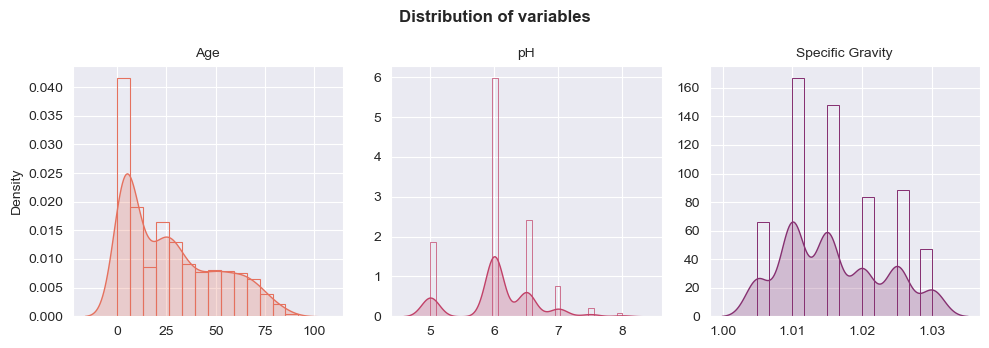

In [12]:
colors = sns.color_palette('flare', n_colors=len(numerical_features))
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))
axs = axs.flat

for i, num_feat in enumerate(numerical_features):
    sns.kdeplot(df, x=num_feat, fill=True, color=colors[i], ax=axs[i])
    sns.histplot(df, x=num_feat, fill=False, stat='density', color=colors[i], ax=axs[i])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_title(num_feat, fontsize=10)

axs[0].set_ylabel("Density")

fig.suptitle("Distribution of variables", fontweight='bold')
fig.tight_layout()
plt.show()

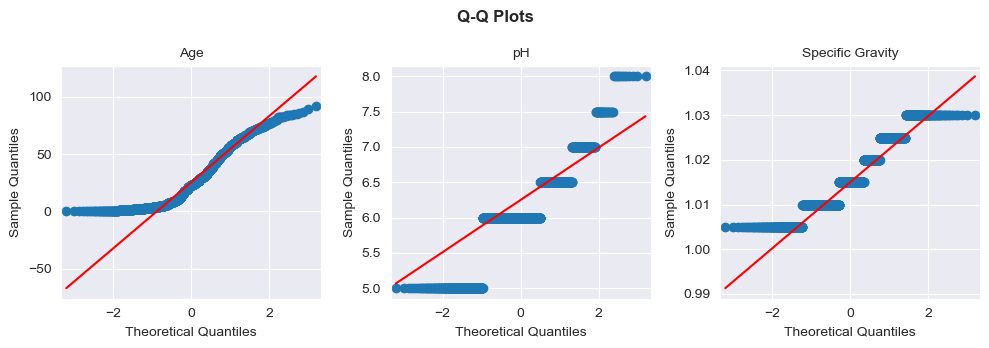

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))
axs = axs.flat

for i, num_feat in enumerate(numerical_features):
    sm.qqplot(df[num_feat], line='q', ax=axs[i], lw=2.1)
    axs[i].set_title(num_feat, fontsize=10)

fig.suptitle("Q-Q Plots", fontweight='bold')
fig.tight_layout()
plt.show()

In [14]:
pg.normality(df[numerical_features])

,W,pval,normal
Age,0.902659,2.786902e-29,False
pH,0.846076,3.384941e-35,False
Specific Gravity,0.915080,1.250025e-27,False


# Preprocess the data

## 1. Feature Selection

In [15]:
df = df.drop('Unnamed: 0', axis=1)

## 2. Drop NAN value
#### There is only a single missing value in the Color column, so we'll drop it

In [16]:
df.loc[df.isnull().any(axis = 1)]

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
1353,18.0,FEMALE,NaN,CLEAR,NEGATIVE,TRACE,6.0,1.02,1-2,0-2,RARE,MODERATE,NONE SEEN,RARE,NEGATIVE


In [17]:
df = df.dropna()

In [18]:
df.isna().sum()

Age                 0
Gender              0
Color               0
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

In [19]:
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

In [20]:
X

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria
0,76.00,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL
1,9.00,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE
2,12.00,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE
3,77.00,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW
4,29.00,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,0.06,MALE,YELLOW,CLEAR,NEGATIVE,NEGATIVE,6.0,1.015,1-2,0-1,RARE,FEW,NONE SEEN,RARE
1432,42.00,MALE,YELLOW,CLEAR,NEGATIVE,NEGATIVE,6.5,1.010,0-2,0-2,RARE,NONE SEEN,NONE SEEN,RARE
1433,47.00,FEMALE,DARK YELLOW,CLEAR,NEGATIVE,TRACE,6.0,1.030,2-4,0-2,MODERATE,MODERATE,NONE SEEN,RARE
1434,57.00,FEMALE,DARK YELLOW,CLEAR,NEGATIVE,TRACE,5.0,1.030,0-2,0-2,PLENTY,PLENTY,NONE SEEN,FEW


## 3. Feature Extraction

In [21]:
def feature_extraction():
    mapping_reference = {
        "ABSENCE_REFERENCE": {
            "NONE SEEN": 0,
            "RARE": 1,
            "FEW": 2,
            "OCCASIONAL": 3,
            "MODERATE": 4,
            "LOADED": 5,
            "PLENTY": 6
        },
        
        "Color": {
            "LIGHT YELLOW": 0,
            "STRAW": 1,
            "AMBER": 2,
            "BROWN": 3,
            "YELLOW": 4,
            "DARK YELLOW": 5,
            "REDDISH YELLOW": 6,
            "REDDISH": 7,
            "LIGHT RED": 8,
            "RED": 9
        },

        "Transparency": {
            "CLEAR": 0,
            "SLIGHTLY HAZY": 1,
            "HAZY": 2,
            "CLOUDY": 3,
            "TURBID": 4
        },

        "Protein_and_Glucose":{
            "NEGATIVE": 0,
            "TRACE": 1,
            "1+": 2,
            "2+": 3,
            "3+": 4,
            "4+": 5
        }
    }

    for ordinal in categorical_features:
        if ordinal in ["Epithelial Cells", "Mucous Threads", "Amorphous Urates", "Bacteria"]:
            X[ordinal] = X[ordinal].map(mapping_reference["ABSENCE_REFERENCE"])

    for ordinal in categorical_features:
        if ordinal in ["Color"]:
            X[ordinal] = X[ordinal].map(mapping_reference["Color"])

    for ordinal in categorical_features:
        if ordinal in ["Transparency"]:
            X[ordinal] = X[ordinal].map(mapping_reference["Transparency"])

    for ordinal in categorical_features:
        if ordinal in ["Protein", "Glucose"]:
            X[ordinal] = X[ordinal].map(mapping_reference["Protein_and_Glucose"])
    
feature_extraction()

In [22]:
X

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria
0,76.00,FEMALE,0,0,0,0,5.0,1.010,1-3,0-2,3,1,0,3
1,9.00,MALE,5,1,0,2,5.0,1.030,1-3,0-2,1,2,2,4
2,12.00,MALE,0,1,0,1,5.0,1.030,0-3,0-2,1,2,4,1
3,77.00,MALE,3,3,0,2,6.0,1.020,5-8,LOADED,1,1,0,2
4,29.00,FEMALE,4,2,0,1,6.0,1.025,1-4,0-2,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,0.06,MALE,4,0,0,0,6.0,1.015,1-2,0-1,1,2,0,1
1432,42.00,MALE,4,0,0,0,6.5,1.010,0-2,0-2,1,0,0,1
1433,47.00,FEMALE,5,0,0,1,6.0,1.030,2-4,0-2,4,4,0,1
1434,57.00,FEMALE,5,0,0,1,5.0,1.030,0-2,0-2,6,6,0,2


In [23]:
le = LabelEncoder()
X['Gender'] = le.fit_transform(X['Gender'])

In [25]:
#Dropping the WBC and RBC columns
X = X.drop(['WBC', 'RBC'], axis=1)

In [53]:
X

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria
0,76.00,0,0,0,0,0,5.0,1.010,3,1,0,3
1,9.00,1,5,1,0,2,5.0,1.030,1,2,2,4
2,12.00,1,0,1,0,1,5.0,1.030,1,2,4,1
3,77.00,1,3,3,0,2,6.0,1.020,1,1,0,2
4,29.00,0,4,2,0,1,6.0,1.025,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1431,0.06,1,4,0,0,0,6.0,1.015,1,2,0,1
1432,42.00,1,4,0,0,0,6.5,1.010,1,0,0,1
1433,47.00,0,5,0,0,1,6.0,1.030,4,4,0,1
1434,57.00,0,5,0,0,1,5.0,1.030,6,6,0,2


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [34]:
y_train.value_counts(normalize=False)

NEGATIVE    947
POSITIVE     57
Name: Diagnosis, dtype: int64

In [35]:
y_test.value_counts(normalize=False)

NEGATIVE    407
POSITIVE     24
Name: Diagnosis, dtype: int64

In [36]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [37]:
def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    return f2_score

def f2_scorer():
    return make_scorer(f2_func)

# Training the Model

#### 1. Simple Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=400)

In [46]:
history = lr.fit(X_train, y_train)

In [71]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [72]:
print("Train Accuracy: ", accuracy_score(y_pred_train, y_train))
print("Test Accuracy: ", accuracy_score(y_pred_test, y_test))

Train Accuracy:  0.9432270916334662
Test Accuracy:  0.9443155452436195


In [111]:
# single_predict = lr.predict([0, 0, 0, 0, 0, 0, 0, 0])
import numpy as np
new_train = np.array(X_train)
new_train[0].shape

zeros = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
zeros = zeros.reshape(1, -1)
zeros.shape

(1, 12)

In [113]:
pred = lr.predict(zeros)
print(pred)

[0]


C:\Users\ACER Nitro 5\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

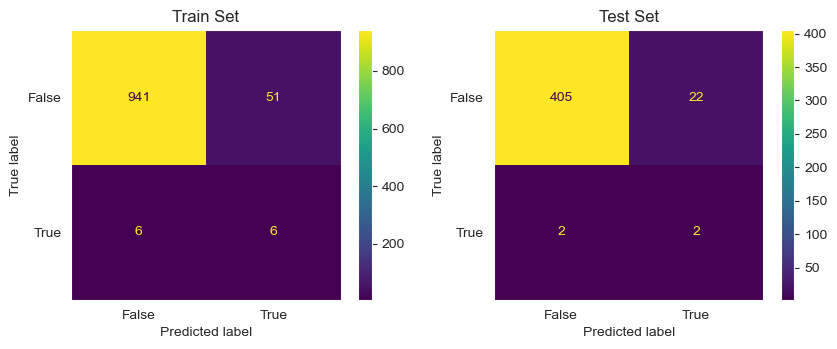

In [76]:
confusion_mat_train = confusion_matrix(y_pred_train, y_train)
confusion_mat_test = confusion_matrix(y_pred_test, y_test)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_mat_train, display_labels = [False, True])
cm_display_train.plot(ax=axs[0])
axs[0].set_title("Train Set")
axs[0].grid(False)

cm_display_train = ConfusionMatrixDisplay(confusion_matrix = confusion_mat_test, display_labels = [False, True])
cm_display_train.plot(ax=axs[1])
axs[1].set_title("Test Set")
axs[1].grid(False)

plt.show()

# Saving the Model

In [78]:
import h5py

def save_coefficients(classifier, filename):
    """Save the coefficients of a linear model into a .h5 file."""
    with h5py.File(filename, 'w') as hf:
        hf.create_dataset("coef",  data=classifier.coef_)
        hf.create_dataset("intercept",  data=classifier.intercept_)
        hf.create_dataset("classes", data=classifier.classes_)

def load_coefficients(classifier, filename):
    """Attach the saved coefficients to a linear model."""
    with h5py.File(filename, 'r') as hf:
        coef = hf['coef'][:]
        intercept = hf['intercept'][:]
        classes = hf['classes'][:]
    classifier.coef_ = coef
    classifier.intercept_ = intercept
    classifier.classes_ = classes

In [79]:
save_coefficients(lr, "urinalysis.h5")

#### 2. Cat Boost Classifier

In [73]:
categorical_predictors = X_train.select_dtypes(include = ['object']).columns.to_list()

In [74]:
cb = CatBoostClassifier(class_weights = {0: 0.05, 1: 0.95}, 
                        random_seed = 42, 
                        verbose = 0,
                        thread_count = 4,
                        iterations = 15)

cb.fit(X_train, y_train, cat_features=categorical_predictors)

In [75]:
y_pred_train = cb.predict(X_train)
y_pred_test = cb.predict(X_test)

print(f'F2 score Train: {fbeta_score(y_train, y_pred_train, beta = 2):.4f}')
print(f'F2 score Test: {fbeta_score(y_test, y_pred_test, beta = 2):.4f}')

F2 score Train: 0.6070
F2 score Test: 0.3409


In [76]:
print("Accuracy: ", accuracy_score(y_pred_train, y_train))
print("Accuracy: ", accuracy_score(y_pred_test, y_test))

Accuracy:  0.8845855925639039
Accuracy:  0.9027777777777778
